In [ ]:
#!pip install numpy
#!pip install sklearn

In [1]:
import numpy as np
import sklearn as skl
import json
import pandas as pd
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [2]:
%matplotlib inline

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



# TP2: Détection de menaces radar

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp2.ipynb 

2 séances de TP sur ce sujet : le 18 octobre (1h30) et le 25 octobre (3h).<br> 
Deadline : 8 novembre 2023, 11h59, par mail à deepetsignal.mva@gmail.com <br> 

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook 
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook. 
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.
    
## Mission


Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus). 

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours. 

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient: 

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence) 
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord. 

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes. 
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus. 

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'. 

Les signaux ont été divisés en deux ensembles indépendants: 
    
- train
- test 
 
Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace. 
    
    
Votre mission (si vous l'acceptez) est de choisir et d'entrainer un algorithme d'apprentissage machine à détecter les menaces sur l'ensemble 'train' et à évaluer ses performances sur l'ensemble 'test'. 

Fort de votre expérience passée, vous décidez de suivre la méthodologie suivante: 

- Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser 
- Sélection d'un algorithme naïf "baseline" de référence: vous définissez un premier algorithme simple et caractérisez ses performances qui serviront de point de comparaison pour qualifier l'apport d'algorithmes plus sophistiqués 
- Vous utilisez la bibliothèque sklearn et notamment ses implémentations d'algorithmes de classification binaire pour définir et entrainer sur l'ensemble 'train' un ou plusieurs algorithmes en capacité de prédire le label menance ou nonmenace de chaque signal (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- Vous qualifiez les performances de vos algorithmes en termes d'accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) ; vous calculez aussi les matrices de confusion (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
    
Pour ce TP nous ne cherchons pas à mettre en place des algorithmes d'apprentissage profond. Ces méthodes pourront être investiguées dans un deuxième temps.
    
 Si les résultats vous semblent décevants, souvenez vous des conseils de votre prédecesseur et mentor G. Abitbol: "toujours donner un coup de pouce à un algo de machine learning  en lui présentant les bonnes données"

Vous pouvez ouvrir un fichier de la façon suivante:

</div>    

In [4]:
pdws = np.load('./radars/train/pdw-0.npz')
dates = pdws['date']
largeurs = pdws['largeur']
frequences=pdws['frequence']
puissances = pdws['puissance']
theta = pdws['theta']
phi = pdws['phi']

with open('./radars/train_labels.json') as f: 
    dict_labels = json.load(f)

for i in range(10):
    print(f"Le signal pdw-{i}.npz est de type: {dict_labels[f'pdw-{i}']}")

Le signal pdw-0.npz est de type: nonmenace
Le signal pdw-1.npz est de type: nonmenace
Le signal pdw-2.npz est de type: menace
Le signal pdw-3.npz est de type: nonmenace
Le signal pdw-4.npz est de type: nonmenace
Le signal pdw-5.npz est de type: menace
Le signal pdw-6.npz est de type: menace
Le signal pdw-7.npz est de type: menace
Le signal pdw-8.npz est de type: menace
Le signal pdw-9.npz est de type: nonmenace


# Analyse visuelle des signaux

In [7]:
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
def visualize(idx):
    pdws = np.load(f'./radars/train/pdw-{idx}.npz')
    target = dict_labels[f'pdw-{idx}']=="nonmenace"
    dates = pdws['date']
    plt.plot((dates[1:]-dates[:-1])/1000.*(np.mean(pdws["frequence"])*1.E9), ("g" if target else "r")+".", label="")
    plt.title("interval between timestamps")
    plt.legend()
    plt.grid()
    # plt.ylim(0, 0.02)
    plt.show()
    
    
interact(visualize, idx=IntSlider(min=0, max=799, step=1));

interactive(children=(IntSlider(value=0, description='idx', max=799), Output()), _dom_classes=('widget-interac…

In [8]:
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
def visualize(idx):
    pdws = np.load(f'./radars/train/pdw-{idx}.npz')
    target = dict_labels[f'pdw-{idx}']=="nonmenace"
    dates = pdws['date']
    # for label in ["largeur", "frequence", "puissance", "theta", "phi"]:
    # for label in ["theta", "phi"]:
    for label in ["puissance"]:
        plt.plot(dates/1000., pdws[label], "g-" if target else "r-", label=label)
        plt.title(label)
    plt.legend()
    plt.grid()
    plt.ylim(-200, -75)
    plt.show()
    
interact(visualize, idx=IntSlider(min=0, max=799, step=1));

interactive(children=(IntSlider(value=0, description='idx', max=799), Output()), _dom_classes=('widget-interac…

In [9]:
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
def visualize(idx):
    pdws = np.load(f'./radars/train/pdw-{idx}.npz')
    target = dict_labels[f'pdw-{idx}']=="nonmenace"
    dates = pdws['date']
    # for label in ["largeur", "frequence", "puissance", "theta", "phi"]:
    # for label in ["theta", "phi"]:
    for label in ["puissance"]:
        # plt.plot(dates[:-1]/1000., np.abs(pdws[label][:-1]-pdws[label][1:])/ (dates[1:]-dates[:-1]), "g-" if target else "r-", label=label)
        plt.plot(dates[:-1]/1000., np.abs(pdws[label][:-1]-pdws[label][1:]), "g-" if target else "r-", label=label)
        plt.title(label)
    plt.legend()
    plt.ylim(0, 20)
    plt.grid()
    plt.show()
    
interact(visualize, idx=IntSlider(min=0, max=799, step=1));

interactive(children=(IntSlider(value=0, description='idx', max=799), Output()), _dom_classes=('widget-interac…

In [10]:
# DATA "UNIFORMIZATION" -> sample all signals on a regular timeline 
# Regular timeline = 10 seconds with 100 elements (we may get a bit of aliasing)
# Then we may navigate this data as a regular data structure (could fit in an excel).
# timestamps are now exactly the same for all signals.


# - la date de début de détection de l'impulsion (en ms)
# - la largeur ou durée de l'impulsion (en ms)
# - la puissance de l'impulsion (en dB / référence) 
# - l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
# - la fréquence de l'impulsion (en Ghz)

def homogenize_data(dataset="train"):
    data = []
    for idx in range(799):
        pdws = np.load(f'./radars/{dataset}/pdw-{idx}.npz')
        with open(f'./radars/{dataset}_labels.json') as f: 
            dict_labels_current = json.load(f)
        target = dict_labels_current[f'pdw-{idx}']=="nonmenace"
        dates = pdws['date']
        uniform_timestamps = np.linspace(0, 10.E3, 100)
        new_dic = {}
        for label, scale in [("largeur", 1.E-3), ("frequence",1.E9), ("puissance" ,1.), ("theta", 1.), ("phi", 1.)]: #normalize to standard units (Hz, seconds)
            non_uniform_value = pdws[label]
            regular_sampling = np.interp(uniform_timestamps, xp=dates, fp=non_uniform_value)
            new_dic[label] = regular_sampling*scale
        new_dic["menace"] = not target
        data.append(new_dic)
    df = pd.DataFrame.from_dict(data)
    return df
df = df_train = homogenize_data(dataset="train")
df_test = homogenize_data(dataset="test")
df.head()

,largeur,frequence,puissance,theta,phi,menace
0,"[0.00029099999999999997, 0.0002911010187641941...","[2222011346.301772, 2201167919.9721026, 221708...","[-125.58248735699023, -115.0846158693843, -108...","[0.9578859532471261, 0.8703978859546783, 0.607...","[1.678935775441994, 1.7243409379102963, 1.6140...",False
1,"[0.00013800000000000002, 0.0001369258365512231...","[3011221070.570557, 2996006530.9250755, 300603...","[-127.176799666022, -157.8781625154061, -137.9...","[2.7962717807754327, -2.829550985701179, -2.48...","[1.5296932038533972, 1.5546468454693552, 1.632...",False
2,"[0.000201, 0.0002018786859303869, 0.000201, 0....","[991990464.3038368, 982743904.1435359, 9898809...","[-149.880060930416, -151.7229884218102, -153.5...","[-2.0412578355641227, -1.9204468635231988, -1....","[1.6722396416013094, 1.7759924411327765, 1.509...",True
3,"[6.800000000000001e-05, 6.928607233324905e-05,...","[1666424017.2021985, 1668061021.2198102, 16641...","[-135.68775777002037, -134.56670065032353, -13...","[-2.621701006244045, -2.2862588398101207, -2.1...","[1.4039557266900524, 1.6190396944122287, 1.690...",False
4,"[0.000324, 0.0003248032831089071, 0.0003248041...","[2207809393.1871147, 2200771938.7002068, 22022...","[-172.60362010919195, -151.87364054688302, -15...","[2.274032092616462, 2.127649080211378, 2.36297...","[1.6134753329852611, 1.6012352706627135, 1.745...",False


In [11]:
# HANDCRAFTED FEATURE COMPUTATION
def get_hand_crafted_features(df, feature_dimension=None):
    inv_freq_mean = np.array([(1./el).mean() for el in df["frequence"]])
    freq_feature = np.array([(1./el).std()/((1./el).mean()) for el in df["frequence"]])
    min_pow = np.array([el.min() for el in df["puissance"]])
    largeur_mean = np.array([el.mean() for el in df["largeur"]])
    freq_std = np.array([el.std() for el in df["frequence"]])
    std_pow = np.array([el[20:50].std() for el in df["puissance"]])
    x = np.stack([freq_std, min_pow, std_pow, freq_feature, inv_freq_mean, largeur_mean], axis=1)
    if feature_dimension is not None:
        x=x[:, :feature_dimension]
    y = [1. if el else 0. for el in df["menace"]]
    return x, y


In [12]:
x_train, y_train = get_hand_crafted_features(df_train)
x_test, y_test = get_hand_crafted_features(df_test)

#features=1 Tree depth=4 accuracy training 76.3% | accuracy test 75.7%
#features=2 Tree depth=4 accuracy training 80.2% | accuracy test 80.0%
#features=3 Tree depth=8 accuracy training 83.2% | accuracy test 80.5%
#features=4 Tree depth=4 accuracy training 80.2% | accuracy test 80.0%


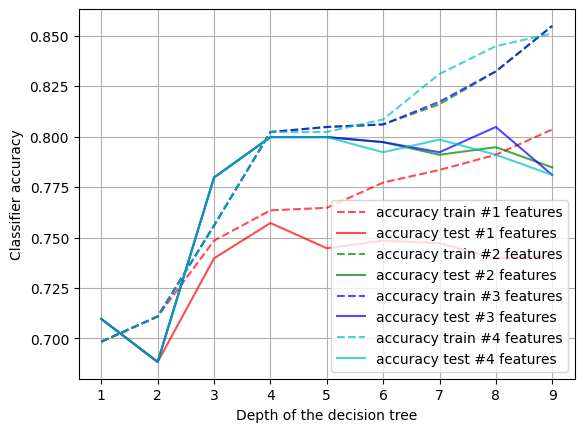

In [13]:
def train_classifier(x_train, x_test, y_train, y_test, feature_dimension=3, debug=False, show=True):
    COLOR_LIST = "rgbckyp"
    if feature_dimension is None:
        x_train_shrink, x_test_shrink = x_train, x_test 
    else:
        x_train_shrink, x_test_shrink = x_train[:, :feature_dimension], x_test[:, :feature_dimension]
    accuracies = []
    depth_list = list(range(1, 10))
    for depth in depth_list:
        dt = DecisionTreeClassifier(max_depth=depth)
        dt.fit(x_train_shrink, y_train)
        y_train_pred = dt.predict(x_train_shrink)
        y_test_pred = dt.predict(x_test_shrink)
        acc_train, acc_test = accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)
        accuracies.append([acc_train, acc_test])
        # if debug:
        #     print(f"accuracy training {acc_train:.1f} | accuracy test {acc_test:.1f}")
    accuracies = np.array(accuracies)
    if debug:
        col=COLOR_LIST[(feature_dimension-1)%len(COLOR_LIST)]
        plt.plot(depth_list, accuracies[:, 0], "--"+col, alpha=0.7, label=f"accuracy train #{feature_dimension} features")
        plt.plot(depth_list, accuracies[:, 1], "-"+col, alpha=0.7, label=f"accuracy test #{feature_dimension} features")
        plt.legend()
        plt.xlabel("Depth of the decision tree")
        plt.ylabel("Classifier accuracy")
        if show:
            plt.grid()
            plt.show()
    best_depth = np.argmax(accuracies[:, 1])
    return accuracies[best_depth, :], depth_list[best_depth]


compare_plots = True
for feature_dimension in range(1, 5):
    accuracies, best_depth = train_classifier(x_train, x_test, y_train, y_test, feature_dimension=feature_dimension, debug=True,  show=not compare_plots)
    print(f"#features={feature_dimension} Tree depth={best_depth} accuracy training {accuracies[0]*100:.1f}% | accuracy test {accuracies[1]*100:.1f}%")
if compare_plots:
    plt.grid()
    plt.show()

In [ ]:
dt

In [ ]:
colors = ["r" if el else "g" for el in df["menace"]]
plt.scatter(inv_freq_mean, min_pow, color=colors, alpha=0.5)
plt.grid()
plt.show()
plt.scatter(freq_feature, min_pow, color=colors, alpha=0.5)
plt.grid()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(freq_feature, inv_freq_mean, min_pow, color=colors)
plt.show()


In [ ]:
colors = ["r" if el else "g" for el in df["menace"]]
for attribute, unit in [("frequence", "[Hz]"), ("largeur", "[s]") , ("puissance", "[db]")]:
    frequences = np.array([el for el in df[attribute]])
    for idx in range(len(phi)):
        plt.plot(np.linspace(0, 10, len(frequences[idx, :])), frequences[idx, :], ".-", color=colors[idx], alpha=0.05)
    plt.xlabel("Time [s]")
    plt.ylabel(f"{attribute} {unit}")
    plt.title("")
    plt.grid()
    plt.show()

In [ ]:
phi = np.array([el.mean() for el in df["phi"]])
theta = np.array([el.mean() for el in df["theta"]])
plt.scatter(theta, phi, color=colors, alpha=0.5)
plt.show()
# no valuable information in the pure angles independantly from the rest of the database

# EXPLORATION

In [ ]:
# colors = np.array([[0., 0., 1.] if el else [1., 0., 0.] for el in df["menace"]])
colors = ["r" if el else "g" for el in df["menace"]]
for at1, at2 in [["frequence", "puissance"]]:    
    attr1, attr2 = 1/np.array([el for el in df[at1]]), np.array([el for el in df[at2]])
    plt.xlabeoutputl(f"1/{at1} mean");plt.ylabel(f"{at2} min")
    plt.scatter(attr1.mean(axis=1), attr2.min(axis=1), color=colors, alpha=0.5)
    plt.grid()
    plt.show()


In [ ]:
# colors = np.array([[0., 0., 1.] if el else [1., 0., 0.] for el in df["menace"]])
colors = ["r" if el else "g" for el in df["menace"]]
for at1, at2 in [["frequence", "largeur"]]:    
    attr1, attr2 = 1/np.array([el for el in df[at1]]), np.array([el for el in df[at2]])
    plt.xlabel(f"{at1} average");plt.ylabel(f"{at2} averaged")
    plt.scatter(attr1.mean(axis=1), attr2.mean(axis=1), color=colors, alpha=0.5)
    plt.grid()
    plt.show()

    
    
    plt.scatter(attr1.std(axis=1), attr2.std(axis=1), color=colors, alpha=0.5)
    plt.xlabel(f"{at1} std");plt.ylabel(f"{at2} std")
    plt.grid()
    # plt.ylim(0, 250)
    # plt.xlim(0, 0.3E8)
    plt.show()



    plt.scatter(attr1.mean(axis=1), attr1.std(axis=1), color=colors, alpha=0.5)
    plt.xlabel(f"{at1} avg");plt.ylabel(f"{at1} std")
    plt.grid()
    plt.show()

    plt.scatter(attr2.mean(axis=1), attr2.std(axis=1), color=colors, alpha=0.5)
    plt.xlabel(f"{at2} avg");plt.ylabel(f"{at2} std")
    plt.grid()
    plt.show()


In [ ]:
plt.scatter(attr1.mean(axis=1), attr1.std(axis=1)/attr1.mean(axis=1), color=colors, alpha=0.5)
plt.xlabel(f"1/{at1} avg");plt.ylabel(f"(1/{at1} std)/(1/{at1} avg)")
plt.grid()
plt.show()

In [ ]:
plt.scatter(attr1.mean(axis=1), attr1.mean(axis=1)/attr1.std(axis=1), color=colors, alpha=0.5)
plt.xlabel(f"{at1} avg");plt.ylabel(f"{at1} std")
plt.grid()
plt.show()


In [ ]:
colors = ["r" if el else "g" for el in df["menace"]]
# plt.plot(np.array([el for el in df["theta"]]), np.array([el for el in df["phi"]]), colors=colors, alpha=0.1)
phi, theta = np.array([el for el in df["theta"]]), np.array([el for el in df["phi"]])
for idx in range(len(phi)):
    if idx%30 ==0:
        plt.plot(theta[idx, :], phi[idx, :], "+", color=colors[idx], alpha=0.1)
plt.xlabel("Theta")
plt.ylabel("Phi")
plt.grid()
plt.show()

In [ ]:
colors = np.array([[0., 0., 1.] if el else [1., 0., 0.] for el in df["menace"]])
colors = ["r" if el else "g" for el in df["menace"]]
assert len(colors) == len(theta.mean(axis=1)) == len(phi.mean(axis=1)), "Data lengths do not match."
plt.grid()
plt.xlabel("Theta average");plt.ylabel("Phi averaged")
plt.scatter(theta.mean(axis=1), phi.mean(axis=1), color=colors, alpha=0.5)
plt.show()

plt.grid()
plt.ylabel("Theta std");plt.ylabel("Phi std")
plt.scatter(theta.std(axis=1), phi.std(axis=1), color=colors, alpha=0.5)
plt.show()


<div class=consignes> et les fichiers d'annotations:</div>

<div class=consignes> On compte sur vous, bonne chance ! </div>